In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import copy
sys.path.append('/users/mtaranov/LongRange3D/')
from models_binnedFeat import LongRangeDNN_FC
#from models import LongRangeDNN_FC
from utils import get_features, get_labels, subsample_data, normalize_features, reconstruct_2d, printMatrix, binarize, zscore, get_2D, plot_prediction, change_scale 
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from dragonn.models import Model, SequenceDNN
#from keras.models import Sequential
#from keras.callbacks import Callback, EarlyStopping
#from keras.layers.core import (
#    Activation, Dense, Dropout, Flatten,
#    Permute, Reshape, TimeDistributedDense
#)
#from keras.layers.convolutional import Convolution2D, MaxPooling2D
#from keras.layers.recurrent import GRU
#from keras.regularizers import l1

#from deeplift import keras_conversion as kc
#from deeplift.blobs import MxtsMode

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: GeForce GTX TITAN X (CNMeM is enabled with initial size: 2500 MB, cuDNN 5005)


In [149]:
contacts='PP'
path='/users/mtaranov/datasets_3d/dist_matched_'+contacts+'/'
X_train = get_features(path+'X_train_thres_10.npy')
y_train = get_labels(path+'y_train_thres_10.npy')
X_valid = get_features(path+'X_valid_thres_10.npy')
y_valid = get_labels(path+'y_valid_thres_10.npy')
X_test = get_features(path+'X_test_thres_10.npy')
y_test = get_labels(path+'y_test_thres_10.npy')

In [150]:
X_train_normalized, X_valid_normalized, X_test_normalized = normalize_features(X_train, X_valid, X_test)

#X_train_normalized_subsampled, y_train_subsampled = subsample_data(X_train_normalized, y_train)
#X_valid_normalized_subsampled, y_valid_subsampled = subsample_data(X_valid_normalized, y_valid)
#X_test_normalized_subsampled, y_test_subsampled = subsample_data(X_test_normalized, y_test)

#X_train_scaled_subsampled, y_train_subsampled = subsample_data(X_train_scaled, y_train)
#X_valid_scaled_subsampled, y_valid_subsampled = subsample_data(X_valid_scaled, y_valid)
#X_test_scaled_subsampled, y_test_subsampled = subsample_data(X_test_scaled, y_test)


In [151]:
X_train_pairs = X_train_normalized.reshape(X_train_normalized.shape[0],X_train_normalized.shape[2]*X_train_normalized.shape[3])
X_valid_pairs = X_valid_normalized.reshape(X_valid_normalized.shape[0],X_valid_normalized.shape[2]*X_valid_normalized.shape[3])
X_test_pairs = X_test_normalized.reshape(X_test_normalized.shape[0],X_test_normalized.shape[2]*X_test_normalized.shape[3])

# without distance

In [2]:
scores_from_10_iter =[]
for i in range(10):
    dnn_normalized = LongRangeDNN_FC(num_features=20, use_deep_CNN=True)
    validation_data = (X_valid_pairs[:,:20], y_valid)
    dnn_normalized.train(X_train_pairs[:,:20], y_train, validation_data)
    dnn_normalized.save(contacts+'dnn_FC_wo_dist', '/users/mtaranov/LongRange3D/')
    print "Iter",i, " summary:"
    print(dnn_normalized.test(X_test_pairs[:,:20], y_test))
    print(dnn_normalized.test(X_train_pairs[:,:20], y_train))
    print(dnn_normalized.test(X_valid_pairs[:,:20], y_valid))
    
    weights='/users/mtaranov/LongRange3D/weights/'+contacts+'dnn_FC_wo_dist.weights.h5'
    json_model='/users/mtaranov/LongRange3D/models/'+contacts+'dnn_FC_wo_dist.arch.json'
    scores = dnn_normalized.deeplift(X_valid_pairs[:,:20], weights, json_model, batch_size=128)
    scores_from_10_iter.append(scores)

# pred_probs_test = dnn_normalized.predict(X_test_normalized[:, :, :10, :])
# #np.save("model_predictions/test_set_upperTriangle_noDiag_reads_with_distances_full_valid.npy", pred_probs_test)
# pred_probs_valid = dnn_normalized.predict(X_valid_normalized[:, :, :10, :])
# #np.save("model_predictions/valid_set_upperTriangle_noDiag_reads_with_distances_full_valid.npy", pred_probs_valid)
# pred_probs_train = dnn_normalized.predict(X_train_normalized[:, :, :10, :])
# #np.save("model_predictions/train_set_upperTriangle_noDiag_reads_with_distances_full_valid.npy", pred_probs_train)

NameError: name 'X_valid_pairs' is not defined

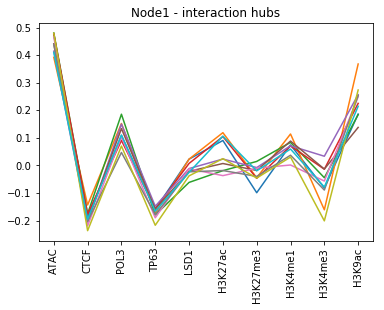

In [153]:
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'LSD1', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac']
for i in range(10):
    # mean feature importance on node 1
    plt.plot(np.mean(scores_from_10_iter[i][:,0:20:2], axis=0))
    x = [float(j) for j in range(np.shape(scores_from_10_iter[i])[1]/2)]
    plt.xticks(x, features, rotation='vertical')
    plt.title('Node1 - interaction hubs')

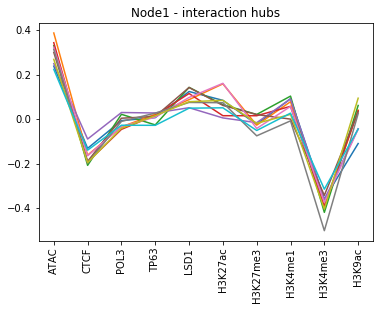

In [154]:
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'LSD1', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac']
for i in range(10):
    # mean feature importance on node 2
    plt.plot(np.mean(scores_from_10_iter[i][:,1:21:2], axis=0))
    x = [float(j) for j in range(np.shape(scores_from_10_iter[i])[1]/2)]
    plt.xticks(x, features, rotation='vertical')
    plt.title('Node1 - interaction hubs')

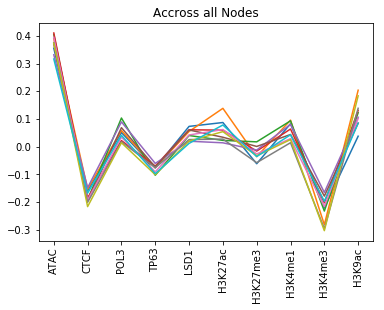

In [155]:
for i in range(10):
    # mean feature importance on node 1
    plt.plot(np.mean(np.concatenate((scores_from_10_iter[i][:,0:20:2], scores_from_10_iter[i][:,1:21:2]), axis=0), axis=0))
    x = [float(j) for j in range(np.shape(scores_from_10_iter[i])[1]/2)]
    plt.xticks(x, features, rotation='vertical')
    plt.title('Accross all Nodes')

In [156]:
i=0
vmin = np.min(np.concatenate((scores_from_10_iter[i][:,0:20:2], scores_from_10_iter[i][:,1:21:2]), axis=1))
vmax = np.max(np.concatenate((scores_from_10_iter[i][:,0:20:2], scores_from_10_iter[i][:,1:21:2]), axis=1))
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'LSD1', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac']
x = [float(i+0.5) for i in range(np.shape(scores)[1]/2)]

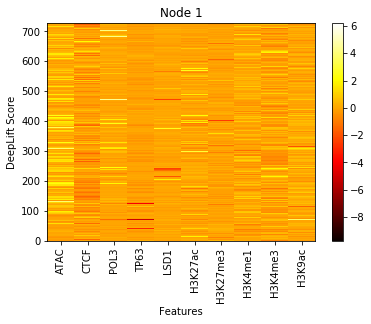

In [157]:
#plt.imshow(scores[:, 0, :, 0], cmap='hot', interpolation='nearest')
i=0
plt.pcolor(scores_from_10_iter[i][:,0:20:2], cmap='hot', vmin=vmin, vmax=vmax) # cmap='RdBu'
plt.xticks(x, features, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('DeepLift Score')
plt.title('Node 1')
plt.colorbar()

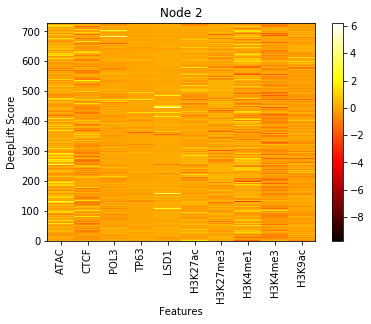

In [158]:
#plt.imshow(scores[:, 0, :, 1], cmap='hot', interpolation='nearest')
i=0
plt.pcolor(scores_from_10_iter[i][:,1:21:2], cmap='hot', vmin=vmin, vmax=vmax) # cmap='RdBu'
plt.xticks(x, features, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('DeepLift Score')
plt.title('Node 2')
plt.colorbar()

# with genomic locations

In [159]:
scores_from_10_iter =[]
for i in range(10):
    dnn_normalized = LongRangeDNN_FC(num_features=22, use_deep_CNN=True)
    validation_data = (X_valid_pairs, y_valid)
    dnn_normalized.train(X_train_pairs, y_train, validation_data)
    dnn_normalized.save(contacts+'dnn_FC_w_dist', '/users/mtaranov/LongRange3D/')
    print "Iter",i, " summary:"
    print(dnn_normalized.test(X_test_pairs, y_test))
    print(dnn_normalized.test(X_train_pairs, y_train))
    print(dnn_normalized.test(X_valid_pairs, y_valid))
    
    weights='/users/mtaranov/LongRange3D/weights/'+contacts+'dnn_FC_w_dist.weights.h5'
    json_model='/users/mtaranov/LongRange3D/models/'+contacts+'dnn_FC_w_dist.arch.json'
    scores = dnn_normalized.deeplift(X_valid_pairs, weights, json_model, batch_size=128)
    scores_from_10_iter.append(scores)

Training model...
Train on 1152 samples, validate on 728 samples
Epoch 1/100
1000/1152 [=========================>....] - ETA: 0s - loss: 2.7348Epoch 0: validation loss: 0.652
Balanced Accuracy: 63.46%	 auROC: 0.690	 auPRC: 0.697	 auPRG: 0.330
Recall at 5%|10%|20% FDR: 1.1%|8.0%|25.8%	 Num Positives: 364	 Num Negatives: 364	 

1152/1152 [==============================] - 0s - loss: 2.7423 - val_loss: 0.6524
Epoch 2/100
1000/1152 [=========================>....] - ETA: 0s - loss: 1.9150Epoch 1: validation loss: 0.733
Balanced Accuracy: 67.03%	 auROC: 0.745	 auPRC: 0.753	 auPRG: 0.504
Recall at 5%|10%|20% FDR: 0.8%|15.1%|46.7%	 Num Positives: 364	 Num Negatives: 364	 

1152/1152 [==============================] - 0s - loss: 1.9917 - val_loss: 0.7328
Epoch 3/100
1000/1152 [=========================>....] - ETA: 0s - loss: 1.5839Epoch 2: validation loss: 0.967
Balanced Accuracy: 60.16%	 auROC: 0.726	 auPRC: 0.705	 auPRG: 0.468
Recall at 5%|10%|20% FDR: 0.0%|0.0%|24.7%	 Num Positives: 364	 

INFO (theano.gof.compilelock): Waiting for existing lock by process '34091' (I am process '24347')
INFO (theano.gof.compilelock): To manually release the lock, delete /users/mtaranov/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.12-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '34091' (I am process '24347')
INFO (theano.gof.compilelock): To manually release the lock, delete /users/mtaranov/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.12-64/lock_dir


Training model...
Train on 1152 samples, validate on 728 samples
Epoch 1/100
1000/1152 [=========================>....] - ETA: 0s - loss: 3.0212Epoch 0: validation loss: 0.697
Balanced Accuracy: 58.65%	 auROC: 0.648	 auPRC: 0.639	 auPRG: 0.276
Recall at 5%|10%|20% FDR: 0.5%|0.5%|5.8%	 Num Positives: 364	 Num Negatives: 364	 

1152/1152 [==============================] - 0s - loss: 2.9876 - val_loss: 0.6967
Epoch 2/100
1000/1152 [=========================>....] - ETA: 0s - loss: 2.1325Epoch 1: validation loss: 0.859
Balanced Accuracy: 61.13%	 auROC: 0.735	 auPRC: 0.741	 auPRG: 0.495
Recall at 5%|10%|20% FDR: 5.8%|9.3%|29.4%	 Num Positives: 364	 Num Negatives: 364	 

1152/1152 [==============================] - 0s - loss: 2.1774 - val_loss: 0.8590
Epoch 3/100
1000/1152 [=========================>....] - ETA: 0s - loss: 1.8765Epoch 2: validation loss: 0.945
Balanced Accuracy: 61.54%	 auROC: 0.719	 auPRC: 0.698	 auPRG: 0.460
Recall at 5%|10%|20% FDR: 0.0%|0.0%|24.7%	 Num Positives: 364	 Nu

In [160]:
scores_from_10_iter[0].shape

(728, 22)

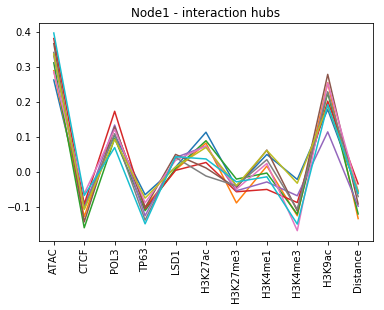

In [161]:
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'LSD1', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac', 'Distance']
for i in range(10):
    # mean feature importance on node 1
    plt.plot(np.mean(scores_from_10_iter[i][:,0:22:2], axis=0))
    x = [float(j) for j in range(np.shape(scores_from_10_iter[i])[1]/2)]
    plt.xticks(x, features, rotation='vertical')
    plt.title('Node1 - interaction hubs')

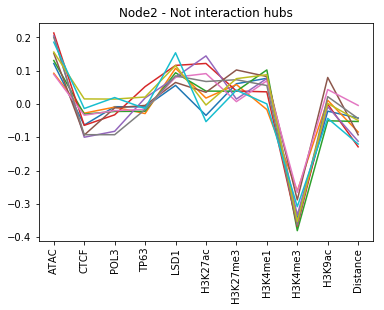

In [162]:
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'LSD1', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac', 'Distance']
for i in range(10):
    # mean feature importance on node 1
    plt.plot(np.mean(scores_from_10_iter[i][:,1:23:2], axis=0))
    x = [float(j) for j in range(np.shape(scores_from_10_iter[i])[1]/2)]
    plt.xticks(x, features, rotation='vertical')
    plt.title('Node2 - Not interaction hubs')

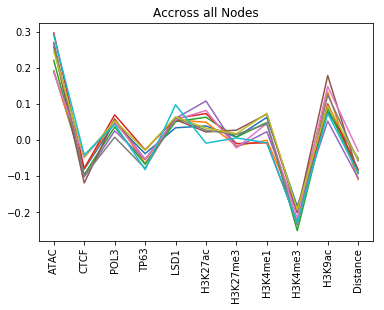

In [163]:
for i in range(10):
    # mean feature importance on node 1
    plt.plot(np.mean(np.concatenate((scores_from_10_iter[i][:,0:22:2], scores_from_10_iter[i][:,1:23:2]), axis=0), axis=0))
    x = [float(j) for j in range(np.shape(scores_from_10_iter[i])[1]/2)]
    plt.xticks(x, features, rotation='vertical')
    plt.title('Accross all Nodes')

# with distance only

In [164]:
dnn_normalized = LongRangeDNN_FC(num_features=2, use_deep_CNN=True)
validation_data = (X_valid_pairs[:,20:], y_valid)
dnn_normalized.train(X_train_pairs[:,20:], y_train, validation_data)

Training model...
Train on 1152 samples, validate on 728 samples
Epoch 1/100
1000/1152 [=========================>....] - ETA: 0s - loss: 3.0237Epoch 0: validation loss: 0.767
Balanced Accuracy: 59.75%	 auROC: 0.595	 auPRC: 0.574	 auPRG: 0.158
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 364	 Num Negatives: 364	 

1152/1152 [==============================] - 0s - loss: 2.9154 - val_loss: 0.7669
Epoch 2/100
1000/1152 [=========================>....] - ETA: 0s - loss: 2.0097Epoch 1: validation loss: 0.873
Balanced Accuracy: 50.00%	 auROC: 0.618	 auPRC: 0.582	 auPRG: 0.199
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 364	 Num Negatives: 364	 

1152/1152 [==============================] - 0s - loss: 2.1090 - val_loss: 0.8728
Epoch 3/100
1000/1152 [=========================>....] - ETA: 0s - loss: 1.8983Epoch 2: validation loss: 1.069
Balanced Accuracy: 50.00%	 auROC: 0.504	 auPRC: 0.475	 auPRG: 0.078
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 364	 Num 

In [165]:
print(dnn_normalized.test(X_test_pairs[:,20:], y_test))
print(dnn_normalized.test(X_train_pairs[:,20:], y_train))

Balanced Accuracy: 60.92%	 auROC: 0.626	 auPRC: 0.591	 auPRG: 0.261
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 229	 Num Negatives: 229	 
Balanced Accuracy: 59.38%	 auROC: 0.608	 auPRC: 0.586	 auPRG: 0.211
Recall at 5%|10%|20% FDR: 0.3%|0.3%|0.3%	 Num Positives: 576	 Num Negatives: 576	 


## with ATAC only

In [166]:
dnn_normalized = LongRangeDNN_FC(num_features=2, use_deep_CNN=True)
validation_data = (X_valid_pairs[:,:2], y_valid)
dnn_normalized.train(X_train_pairs[:,:2], y_train, validation_data)

Training model...
Train on 1152 samples, validate on 728 samples
Epoch 1/100
1000/1152 [=========================>....] - ETA: 0s - loss: 2.2931Epoch 0: validation loss: 0.946
Balanced Accuracy: 55.49%	 auROC: 0.612	 auPRC: 0.626	 auPRG: 0.165
Recall at 5%|10%|20% FDR: 0.0%|3.0%|5.8%	 Num Positives: 364	 Num Negatives: 364	 

1152/1152 [==============================] - 0s - loss: 2.1897 - val_loss: 0.9462
Epoch 2/100
1000/1152 [=========================>....] - ETA: 0s - loss: 2.0208Epoch 1: validation loss: 0.808
Balanced Accuracy: 61.26%	 auROC: 0.663	 auPRC: 0.680	 auPRG: 0.327
Recall at 5%|10%|20% FDR: 5.8%|5.8%|11.5%	 Num Positives: 364	 Num Negatives: 364	 

1152/1152 [==============================] - 0s - loss: 1.9991 - val_loss: 0.8080
Epoch 3/100
1000/1152 [=========================>....] - ETA: 0s - loss: 1.6223Epoch 2: validation loss: 0.888
Balanced Accuracy: 60.85%	 auROC: 0.644	 auPRC: 0.667	 auPRG: 0.260
Recall at 5%|10%|20% FDR: 4.7%|6.0%|16.2%	 Num Positives: 364	 Nu

In [167]:
print(dnn_normalized.test(X_test_pairs[:,:2], y_test))
print(dnn_normalized.test(X_train_pairs[:,:2], y_train))

Balanced Accuracy: 61.35%	 auROC: 0.669	 auPRC: 0.671	 auPRG: 0.316
Recall at 5%|10%|20% FDR: 1.3%|1.3%|10.5%	 Num Positives: 229	 Num Negatives: 229	 
Balanced Accuracy: 62.15%	 auROC: 0.681	 auPRC: 0.706	 auPRG: 0.329
Recall at 5%|10%|20% FDR: 4.9%|11.6%|35.6%	 Num Positives: 576	 Num Negatives: 576	 


# Print prediction

In [168]:
indx_train = np.load('/users/mtaranov/NN_thres5max_datasets/dist_matched/indx_train_thres_10.npy')
indx_valid = np.load('/users/mtaranov/NN_thres5max_datasets/dist_matched/indx_valid_thres_10.npy')
indx_test = np.load ('/users/mtaranov/NN_thres5max_datasets/dist_matched/indx_test_thres_10.npy')

In [169]:
labels_all=(np.concatenate((y_train, y_valid, y_test), axis=0)).astype(int)
preds_all=(np.concatenate((pred_probs_train, pred_probs_valid, pred_probs_test), axis=0))
indx_all=np.concatenate((indx_train, indx_valid, indx_test), axis=0)

labels_chr1 = labels_all[np.ravel(np.where(indx_all[:,2]==1))]
preds_chr1 = preds_all[np.ravel(np.where(indx_all[:,2]==1))]
indx_chr1 = indx_all[np.ravel(np.where(indx_all[:,2]==1))]

NameError: name 'pred_probs_train' is not defined

In [ ]:
NumberOfNodes=2272
preds_chr1_2d, labels_chr1_2d = get_2D(indx_chr1, preds_chr1, labels_chr1, NumberOfNodes)
# preds_test_2d, labels_test_2d = get_2D(indx_test, preds_test, labels_test, NumberOfNodes)

In [ ]:
# printMatrix(preds_chr1_2d, '', 1, 1, title='preds')
# printMatrix(labels_chr1_2d, '', 1, 1, title='Captures')

In [ ]:
zoomIn_window = (400,460)
NumberOfNodes=2272
plot_prediction(change_scale(preds_chr1_2d)+change_scale(preds_chr1_2d).T, change_scale(labels_chr1_2d)+change_scale(labels_chr1_2d).T, zoomIn_window, )